# Easy Money - Modelo de propensión a compra

Mensaje de Carol: Una vez que hayamos hecho el análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a comprar nuestros productos así que te pido por favor hagas un modelo de propensión a compra, se que tenemos muchos productos, así que te dejo a tu criterio científico qué productos elegir, o pueden ser varios, ya me sorprenderás

Vamos a desarrollar un modelo capaz de **predecir si un cliente es propenso a contratar un producto de Easy Money, teniendo en cuenta sus características**.

## Importación de librerías

In [1]:
# Importamos las librerias necesarias.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
from sklearn import model_selection 
from sklearn import metrics
from sklearn.model_selection import train_test_split


## Importación de datos

De las tablas que tenemos disponibles en BBDD, las que serán de utilidad para este modelo son customer_sociodemographics, customer_commercial_activity.
<p>Guardamos los datos de las tablas en dataframes distintos que limpiaremos, y posteriormente uniremos en un único dataframe 


In [3]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME1 = 'customer_sociodemographics.csv'
FILE1 = os.path.join(DATA_PATH, FILE_NAME1)

FILE_NAME2 = 'customer_commercial_activity.csv'
FILE2 = os.path.join(DATA_PATH, FILE_NAME2)


print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 1:', FILE1)
print('file 2:', FILE2)
print('data path:', DATA_PATH)

current path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/Dataframe_modelo_credit_card
parent path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/
file 1: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_sociodemographics.csv
file 2: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_commercial_activity.csv
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/


In [4]:
df_cs = pd.read_csv(FILE1, index_col=0)
df_cca = pd.read_csv(FILE2, index_col=0)

## 1: Data Understanding

### 1.1: Análisis Univariante de datos de las distintos datasets que vamos a usar

#### 1.1.1 Analizamos la tabla customer_sociodemographics

In [5]:
# Datos generales 

df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 409.4+ MB


In [6]:
# Visualización de los datos
df_cs.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [7]:
# Recuento de nulos 

df_cs.isna().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

De entrada, analizamos la columna "deceased" para eliminar los clientes fallecidos y quedarnos con aquellos que actualmente son reales

In [8]:
df_cs['deceased'].value_counts()

deceased
N    5961849
S       1075
Name: count, dtype: int64

In [9]:
df_cs = df_cs[(df_cs['deceased']  == 'N')]
df_cs['deceased'].value_counts()

deceased
N    5961849
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes no fallecidos, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [10]:
del(df_cs['deceased'])

Analizamos también la columna country_id para ver si vale la pena quedarnos con todos los países de la BBDD 

In [11]:
df_cs['country_id'].value_counts()

country_id
ES    5959602
GB        441
FR        225
DE        199
US        195
CH        189
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: count, dtype: int64

Vemos que los valores de los países distintos a ES son muy pequeños y no aportarán demasiado valor a nuestro modelo. Nos quedamos solamente con los registros que son country_id = ES

In [12]:
df_cs = df_cs[(df_cs['country_id']  == 'ES')]
df_cs['country_id'].value_counts()

country_id
ES    5959602
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes de ES, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [13]:
del(df_cs['country_id'])

Según el diccionario de las tablas, region_code es el código de provincia. Este dato sí puede ser relevante, pero vemos que tiene nulos. Como estamos ante un modelo de clasificación binaria, podemos rellenar los nulos con un valor como -1, para que se sean agrupados en un bloque propio.

In [14]:
df_cs['region_code'].fillna(-1, inplace=True)

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/1372854579.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cs['region_code'].fillna(-1, inplace=True)


La columna gender también tenía nulos, pero son muy pocos en relación al total del dataset. Analizamos cuántos nulos quedan después de los cambios ya realizados y elimnamos estas filas por ser muy pocas

In [15]:
df_cs['gender'].isna().sum()

25

In [16]:
df_cs = df_cs.dropna(subset =['gender'])

Analizamos la columna salary 

In [17]:
df_cs['salary'].value_counts()

salary
451931.22    709
288997.44    546
135522.15    466
128318.52    458
104563.80    436
            ... 
127111.23      1
100303.05      1
125135.46      1
188185.68      1
167276.64      1
Name: count, Length: 257626, dtype: int64

In [18]:
df_cs['salary'].describe()

count    4.420911e+06
mean     1.155810e+05
std      2.000189e+05
min      1.202730e+03
25%      6.141354e+04
50%      8.843742e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64

Vemos que todos los valores son positivos, que la diferencia entre el salario mayor y el salario menor es muy grande, y que la media por tanto es muy elevada también. Igualmente, según el diccionario de la BBDD, se trata del salario de la unidad familiar y consideramos que este valor es importante a la hora de determinar la contratación. Al haber muchos nulos, y al ser el modelo de clasificación binaria, vamos a asignar a los nulos el valor -1

In [19]:
df_cs['salary'].fillna(-1, inplace=True)

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/3059662271.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cs['salary'].fillna(-1, inplace=True)


Transformamos la columna region_code de float a int

In [20]:
df_cs["region_code"] = df_cs["region_code"].astype(int)

Transformamos la columna pk_partition a fecha

In [21]:
df_cs["pk_partition"] = pd.to_datetime(df_cs["pk_partition"])


Finalmente, la tabla de customer_sociodemographics quedará así:

In [22]:
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5959577 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   pk_cid        int64         
 1   pk_partition  datetime64[ns]
 2   region_code   int64         
 3   gender        object        
 4   age           int64         
 5   salary        float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 318.3+ MB


#### 1.1.2 Analizamos la tabla customer_commercial_activity

In [23]:
# Datos generales 

df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 318.5+ MB


In [24]:
# Visualización de los datos
df_cca.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [25]:
# Recuento de nulos 

df_cca.isna().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [26]:
pd.set_option('display.max_rows', 100)

In [27]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE    53.413469
KFC    15.276786
KHQ    10.125061
KAT     7.137080
KHK     3.948564
KHM     3.029062
KHN     1.859966
KFA     1.355428
KHD     1.301894
RED     1.039488
KHL     0.715897
KHF     0.354329
KHO     0.141461
KAZ     0.096657
KHC     0.089899
KBG     0.028508
KEH     0.012487
KHP     0.011853
007     0.010515
013     0.006810
KAG     0.005746
KAS     0.005232
KBZ     0.003396
KAA     0.003311
KAR     0.002693
KAY     0.002556
KAF     0.002110
KAB     0.001630
KFD     0.001561
KCC     0.001527
KAW     0.001115
KAQ     0.000892
KDH     0.000875
KAE     0.000823
KCH     0.000823
KCB     0.000806
KAD     0.000772
KAM     0.000738
KAH     0.000686
KAK     0.000583
KAJ     0.000566
KDT     0.000395
KFF     0.000377
KBO     0.000360
KEY     0.000343
KGC     0.000292
004     0.000292
KFS     0.000292
KCL     0.000292
KBE     0.000292
KBH     0.000292
KFK     0.000292
KGN     0.000292
KCI     0.000292
KGX     0.000292
KDR     0.000274
KFL     0.000223
KBW     0.000206


Vemos muchos valores de Entry Channel que son muy pocos en comparación con los valores mayoritarios. Elegimos los canales de entrada que tengan una proporción mayor al 1% y agrupamos el resto en Others

In [28]:
value_counts = (df_cca['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_cca['entry_channel'] = df_cca['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [29]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE       53.413469
KFC       15.276786
KHQ       10.125061
KAT        7.137080
KHK        3.948564
KHM        3.029062
KHN        1.859966
Others     1.513202
KFA        1.355428
KHD        1.301894
RED        1.039488
Name: proportion, dtype: float64

Analizamos la columna segment para ver los valores únicos, sabiendo que también tiene nulos

In [30]:
df_cca['segment'].value_counts()

segment
03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: count, dtype: int64

Rellenamos NaN de channel y segment con un valor identificativo como 'Not defined'

In [31]:
df_cca["entry_channel"].fillna('Not defined', inplace=True)
df_cca["segment"].fillna('Not defined', inplace=True)

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/2969524961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cca["entry_channel"].fillna('Not defined', inplace=True)
/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/2969524961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [32]:
df_cca.isna().sum()

pk_cid             0
pk_partition       0
entry_date         0
entry_channel      0
active_customer    0
segment            0
dtype: int64

In [33]:
df_cca['active_customer'].value_counts()

active_customer
0.0    3557573
1.0    2405351
Name: count, dtype: int64

Transformarmos active_customer de float a int

In [34]:
df_cca["active_customer"] = df_cca["active_customer"].astype(int)

Transformamos las columna pk_partition y entry_date a fecha

In [35]:
df_cca["pk_partition"] = pd.to_datetime(df_cca["pk_partition"])
df_cca["entry_date"] = pd.to_datetime(df_cca["entry_date"])

Eliminamos la columna de entry_date ya que la fecha que nos interesa realmente es la fecha de venta dela tabla sales

In [36]:
del(df_cca['entry_date'])

Finalmente, la tabla de customer_commercial_activity quedará así:

In [37]:
df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   pk_cid           int64         
 1   pk_partition     datetime64[ns]
 2   entry_channel    object        
 3   active_customer  int64         
 4   segment          object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 273.0+ MB


## 2: Construcción del dataset para el modelo

Vamos a hacer un inner merge de todos los datasets, ya que nos interesa agrupar toda la información analizada en un único dataframe, que contenga toda la información por el id de cliente.

In [38]:
df_merged = pd.merge(
    left = df_cca, 
    right = df_cs,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [39]:
df_merged.head()

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary
0,1375586,2018-01-01,Others,1,02 - PARTICULARES,29,H,35,87218.10
1,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74
2,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11
3,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54
4,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00


In [40]:
pd.set_option('display.max_rows', 1000)

Cargamos un csv correspondiente a las compras de pension plan, donde tendrá para cada pk_cid un valor de 1 en el mes de su compra y tendrá 0 para tenencia o cancelación.

In [41]:

print(DATA_PATH)

df_con_reg = pd.read_csv(os.path.join(DATA_PATH, 'reg_credit_card.csv'), sep = ';', low_memory=False, index_col=0)

/Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/


In [42]:
df_con_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 15891 to 1079479
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   pk_partition     1048575 non-null  object
 1   reg_credit_card  1048575 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


In [43]:
df_con_reg.head()

,pk_partition,reg_credit_card
pk_cid,,
15891,01/07/2018,0
15891,01/08/2018,0
16063,01/11/2018,0
16063,01/12/2018,0
16063,01/01/2019,0


In [44]:
df_con_reg['pk_partition'] = pd.to_datetime(df_con_reg['pk_partition'], format = '%d/%m/%Y' )

In [45]:
df_con_reg.head()

,pk_partition,reg_credit_card
pk_cid,,
15891,2018-07-01,0
15891,2018-08-01,0
16063,2018-11-01,0
16063,2018-12-01,0
16063,2019-01-01,0


In [46]:
df_con_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 15891 to 1079479
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   pk_partition     1048575 non-null  datetime64[ns]
 1   reg_credit_card  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.0 MB


In [47]:
df_con_reg.isnull().sum()

pk_partition       0
reg_credit_card    0
dtype: int64

Hacemos merge con el df de los datos de cliente y la compra de la credit card, uniendo con un inner por pk_cid y pk_partition 

In [48]:
df_con_reg_merged = pd.merge(
    left = df_merged, 
    right = df_con_reg,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [49]:
df_con_reg_merged.head(50)

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0
5,1050616,2018-01-01,KHE,0,03 - UNIVERSITARIO,24,H,23,295590.36,0
6,1050617,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,H,23,113316.66,0
7,1050619,2018-01-01,KHE,0,03 - UNIVERSITARIO,20,H,24,-1.00,0
8,1050620,2018-01-01,KHE,0,03 - UNIVERSITARIO,10,H,23,113194.98,0
9,1050621,2018-01-01,KHE,0,03 - UNIVERSITARIO,50,V,23,72575.88,0


In [50]:
df_con_reg_merged['reg_credit_card'].value_counts(normalize=True)

reg_credit_card
0    0.995695
1    0.004305
Name: proportion, dtype: float64

## Creamos datasets con compras y no compras de la credit card

In [51]:
df_con_reg_merged 

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0
...,...,...,...,...,...,...,...,...,...,...
1047514,1018682,2019-05-01,KAT,0,02 - PARTICULARES,28,V,88,35310.57,0
1047515,1018679,2019-05-01,KFA,1,02 - PARTICULARES,28,V,34,61180.11,0
1047516,1018676,2019-05-01,KFA,0,02 - PARTICULARES,28,H,74,63867.48,0
1047517,1018675,2019-05-01,KFC,0,02 - PARTICULARES,29,H,15,-1.00,0


In [52]:
credit_card_purch = df_con_reg_merged.loc[(df_con_reg_merged['reg_credit_card'] == 1)]

In [53]:
credit_card_purch

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
71,1050659,2018-01-01,KFC,1,02 - PARTICULARES,7,V,39,-1.00,1
214,1050911,2018-01-01,KHE,1,03 - UNIVERSITARIO,46,H,29,50229.09,1
727,1051800,2018-01-01,KFC,1,02 - PARTICULARES,15,V,35,-1.00,1
737,1051833,2018-01-01,KFC,1,03 - UNIVERSITARIO,26,V,35,68036.19,1
745,1051759,2018-01-01,KAT,1,02 - PARTICULARES,45,V,52,27585.30,1
...,...,...,...,...,...,...,...,...,...,...
1047085,1018925,2019-05-01,KFC,1,02 - PARTICULARES,36,H,47,109110.84,1
1047180,1019005,2019-05-01,KFC,1,01 - TOP,46,H,34,38723.37,1
1047375,1018436,2019-05-01,KFC,1,01 - TOP,38,V,38,65458.23,1
1047377,1018459,2019-05-01,KFC,1,02 - PARTICULARES,28,H,35,90618.96,1


In [54]:
credit_card_no_purch = df_con_reg_merged.loc[(df_con_reg_merged['reg_credit_card'] == 0)]

In [55]:
credit_card_no_purch 

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0
...,...,...,...,...,...,...,...,...,...,...
1047514,1018682,2019-05-01,KAT,0,02 - PARTICULARES,28,V,88,35310.57,0
1047515,1018679,2019-05-01,KFA,1,02 - PARTICULARES,28,V,34,61180.11,0
1047516,1018676,2019-05-01,KFA,0,02 - PARTICULARES,28,H,74,63867.48,0
1047517,1018675,2019-05-01,KFC,0,02 - PARTICULARES,29,H,15,-1.00,0


Queremos utilizar las fechas del dataset credit_card_purch anteriores para montar el dataset final con los datos de clientes.
Ya hemos identificado los 1, solo queremos las fechas. 
Cuando tengamos las fechas, podemos ir a los no-purch y sacar los datos anteriores a esas fechas (datetime).
De aquí tendremos clientes que han comprado pero con su comportamiento o descripción el mes anterior a la compra.




In [56]:
# Creamos una nueva columna con los datos de la pk_partition del mes anterior a la compra desde el data frame de purchase
credit_card_purch['pk_part_prev_month'] = credit_card_purch['pk_partition'] - pd.DateOffset(months=1)

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/132286313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_card_purch['pk_part_prev_month'] = credit_card_purch['pk_partition'] - pd.DateOffset(months=1)


In [57]:
credit_card_purch.head()

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card,pk_part_prev_month
71,1050659,2018-01-01,KFC,1,02 - PARTICULARES,7,V,39,-1.00,1,2017-12-01
214,1050911,2018-01-01,KHE,1,03 - UNIVERSITARIO,46,H,29,50229.09,1,2017-12-01
727,1051800,2018-01-01,KFC,1,02 - PARTICULARES,15,V,35,-1.00,1,2017-12-01
737,1051833,2018-01-01,KFC,1,03 - UNIVERSITARIO,26,V,35,68036.19,1,2017-12-01
745,1051759,2018-01-01,KAT,1,02 - PARTICULARES,45,V,52,27585.30,1,2017-12-01


In [58]:
credit_card_purch.shape

(4510, 11)

Reducimos el credit card purch a los datos de pk_cid y fecha de partición del mes anterior a la compra. Nos servirá más adelante para conocer qué caracteristicas tiene un cliente en este mes antes de comprar.

In [59]:
credit_card_purch = credit_card_purch[['pk_cid', 'pk_part_prev_month']]

Habiendo obtenido el dataframe con los clientes que compran y el pk_partition_del mes anterior a la compra, queremos sacar los datos de estos clientes para la fecha del mes anterior a la compra, para saber que características tenian.

In [60]:
# Mergeamos por pk_cid y pk_partition del mes anterior a compra con el dataframe de las no compras

df_customers_purchased = pd.merge(
    left = credit_card_purch, 
    right = credit_card_no_purch, 
    left_on = ('pk_cid', 'pk_part_prev_month'), 
    right_on=('pk_cid', 'pk_partition'),
    how='inner'
    )

In [64]:
df_customers_purchased.shape

(3079, 11)

Se pierden entradas ya que para los meses previos a la primera partición no coincide con ninguna entrada (NaN).

Aqui vemos el dataframe resultante de las características del mes antes de la compra solo para aquellos clientes que han comprado el credit card.

In [61]:
df_customers_purchased.isna().sum()

pk_cid                0
pk_part_prev_month    0
pk_partition          0
entry_channel         0
active_customer       0
segment               0
region_code           0
gender                0
age                   0
salary                0
reg_credit_card       0
dtype: int64

In [62]:
credit_card_no_purch .info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043009 entries, 0 to 1047518
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   pk_cid           1043009 non-null  int64         
 1   pk_partition     1043009 non-null  datetime64[ns]
 2   entry_channel    1043009 non-null  object        
 3   active_customer  1043009 non-null  int64         
 4   segment          1043009 non-null  object        
 5   region_code      1043009 non-null  int64         
 6   gender           1043009 non-null  object        
 7   age              1043009 non-null  int64         
 8   salary           1043009 non-null  float64       
 9   reg_credit_card  1043009 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 87.5+ MB


In [63]:
df_customers_purchased.head(10)

,pk_cid,pk_part_prev_month,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,560733,2018-01-01,2018-01-01,KFA,1,01 - TOP,28,V,66,144377.82,0
1,532532,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,28,H,41,113208.81,0
2,502038,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,28,V,40,105847.65,0
3,474925,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,33,H,37,165653.64,0
4,844522,2018-01-01,2018-01-01,KFC,1,02 - PARTICULARES,28,V,42,141704.73,0
5,679714,2018-01-01,2018-01-01,KAT,0,02 - PARTICULARES,28,H,55,119480.88,0
6,645092,2018-01-01,2018-01-01,KFC,1,03 - UNIVERSITARIO,28,V,29,74371.20,0
7,734299,2018-01-01,2018-01-01,KAT,1,01 - TOP,28,V,40,96465.69,0
8,121495,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,28,V,54,128318.52,0
9,138218,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,11,H,51,112350.15,0


Como sabemos que todos los clientes del df_cuestomers_purchased nos han comprado el credit card, le decimos que reemplace el 0 de compra por el 1.

In [64]:
df_customers_purchased['reg_credit_card'].replace({0: 1}, inplace=True)

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/3197412289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_customers_purchased['reg_credit_card'].replace({0: 1}, inplace=True)


In [65]:
df_customers_purchased.shape

(3079, 11)

Vemos que los clientes que nos han comprado son 3079.

Para tener un modelo balanceado hacen falta clientes que no hayan comprado ni vayan a comprar. Tenemos que ver que el modelo sea balanceado para cada mes de partición. Para eso, hacemos un left merge con el df de los clientes que han comprado, según el pk_cid. Quedandonos así con el pk_cid de clientes que no coinciden en ninguna de las tablas (es decir, con los pk_cid que no tengan compra de credit card). Indicator=True crea una columna merge que indica la procedencia de los datos, left only, right only o both.

In [66]:
df_customers_no_purchased = pd.merge(
    left=credit_card_no_purch, 
    right=credit_card_purch, 
    left_on=('pk_cid', 'pk_partition'), 
    right_on=('pk_cid', 'pk_part_prev_month'),
    how='left',
    indicator=True
)

In [67]:
df_customers_no_purchased

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card,pk_part_prev_month,_merge
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0,NaT,left_only
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0,NaT,left_only
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0,NaT,left_only
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0,NaT,left_only
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0,NaT,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...
1043004,1018682,2019-05-01,KAT,0,02 - PARTICULARES,28,V,88,35310.57,0,NaT,left_only
1043005,1018679,2019-05-01,KFA,1,02 - PARTICULARES,28,V,34,61180.11,0,NaT,left_only
1043006,1018676,2019-05-01,KFA,0,02 - PARTICULARES,28,H,74,63867.48,0,NaT,left_only
1043007,1018675,2019-05-01,KFC,0,02 - PARTICULARES,29,H,15,-1.00,0,NaT,left_only


Reescribimos el dataframe diciendo que despues de haber creado la columna merge que indica la procedencia de datos, solo nos queremos quedar con aquellos que para esa columna procedan solo de left_only, es decir, del dataset que no tiene compras. Además le pedimos que elimine la columna merge porque no nos interesa. Asi nos aseguramos que en el dataset de clientes que no han comprado solo tenemos aquellos clientes que no han comprado ni pretenden comprar en el dataset.

In [68]:
df_customers_no_purchased = df_customers_no_purchased[df_customers_no_purchased['_merge'] == 'left_only'].drop(columns=['_merge'])

In [69]:
df_customers_no_purchased.isna().sum()

pk_cid                      0
pk_partition                0
entry_channel               0
active_customer             0
segment                     0
region_code                 0
gender                      0
age                         0
salary                      0
reg_credit_card             0
pk_part_prev_month    1039930
dtype: int64

In [70]:
df_customers_no_purchased

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card,pk_part_prev_month
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0,NaT
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0,NaT
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0,NaT
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0,NaT
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0,NaT
...,...,...,...,...,...,...,...,...,...,...,...
1043004,1018682,2019-05-01,KAT,0,02 - PARTICULARES,28,V,88,35310.57,0,NaT
1043005,1018679,2019-05-01,KFA,1,02 - PARTICULARES,28,V,34,61180.11,0,NaT
1043006,1018676,2019-05-01,KFA,0,02 - PARTICULARES,28,H,74,63867.48,0,NaT
1043007,1018675,2019-05-01,KFC,0,02 - PARTICULARES,29,H,15,-1.00,0,NaT


De aquí tendremos que seleccionar, al azar, la misma cantidad de filas de aquellos clientes que compraron para un mismo mes, para un modelo balanceado. En total, hacen falta 3079 que no hayan comprado pero tendremos que ver cuantos hacen falta para cada pk_partition.

Seguiremos los siguientes pasos: 
- Seleccionar 3079 clientes del no-purchase por mes.
- Concatenar df df_customers_purchased + df_customers_no_purchased.
- Eliminar pk_partition_pre_month.

In [71]:
# Contar el número de clientes por pk_partition en df_customers_purchased
customers_count = df_customers_purchased.groupby('pk_partition')['pk_cid'].count()

In [72]:
# Crear un DataFrame vacío para almacenar las muestras
df_customers_no_purchased_samples = pd.DataFrame()

# Recorrer cada pk_partition en customers_count
for pk_partition, count in customers_count.items():
    # Filtrar clientes sin compra para el pk_partition actual
    df_no_purchase_filtered = df_customers_no_purchased[df_customers_no_purchased['pk_partition'] == pk_partition]
    
    # Muestrear el mismo número de clientes sin compra
    if len(df_no_purchase_filtered) >= count:
        df_sampled = df_no_purchase_filtered.sample(n=count, random_state=42)  # random_state para reproducibilidad
    else:
        # Si hay menos clientes sin compra que con compra, tomar todos
        df_sampled = df_no_purchase_filtered
    
    # Agregar la muestra al DataFrame de resultados
    df_customers_no_purchased_samples = pd.concat([df_customers_no_purchased_samples, df_sampled])

# Resetear el índice del DataFrame resultante
df_customers_no_purchased_samples.reset_index(drop=True, inplace=True)

Con la iteración anterior hemos hecho un groupby para conocer el número de entradas por pk_partition para el dataset de compras. En función de este número, hemos creado un nuevo dataframe que filtra por número de pk_partition en el dataset de no compras y se rellena de forma aleatoria con valores de ese dataset. Finalmente, este dataset contendrá las mismas entradas que el dataset de compras para cada pk_partition. Hemos puesto una línea para que si no hubiesen suficientes entradas del dataset sin compras para esa pk_partition, coja todos los valores disponibles.

In [73]:
df_customers_no_purchased_samples.shape

(3079, 11)

Comrpobamos que se ha ejecutado bien la función que queríamos.

In [74]:
len(df_customers_purchased.loc[df_customers_purchased['pk_partition']=='2018-11-01'])

187

In [75]:
len(df_customers_no_purchased_samples.loc[df_customers_no_purchased_samples['pk_partition']=='2018-11-01'])

187

In [76]:
df_customers_no_purchased_samples

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card,pk_part_prev_month
0,1015997,2018-01-01,KFC,1,02 - PARTICULARES,38,V,52,-1.00,0,NaT
1,1079007,2018-01-01,KFC,0,02 - PARTICULARES,28,V,33,80858.10,0,NaT
2,1027801,2018-01-01,KHE,0,03 - UNIVERSITARIO,32,H,25,55433.58,0,NaT
3,1004017,2018-01-01,KFC,1,02 - PARTICULARES,28,H,33,185682.81,0,NaT
4,1028855,2018-01-01,KHE,1,03 - UNIVERSITARIO,25,H,32,20522.91,0,NaT
...,...,...,...,...,...,...,...,...,...,...,...
3074,1074887,2019-04-01,KHE,1,03 - UNIVERSITARIO,28,H,25,276768.36,0,NaT
3075,1074038,2019-04-01,KHE,1,03 - UNIVERSITARIO,47,H,23,94658.13,0,NaT
3076,1012163,2019-04-01,KFC,0,02 - PARTICULARES,28,H,33,-1.00,0,NaT
3077,1074796,2019-04-01,KHE,0,03 - UNIVERSITARIO,9,H,24,85282.08,0,NaT


## Concatenamos los dataframes 

Unimos los clientes de los dataframes para tener nuestro dataset para entrenar el modelo.

In [77]:
df = pd.concat([df_customers_purchased, df_customers_no_purchased_samples], axis=0)

In [78]:
df

,pk_cid,pk_part_prev_month,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,560733,2018-01-01,2018-01-01,KFA,1,01 - TOP,28,V,66,144377.82,1
1,532532,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,28,H,41,113208.81,1
2,502038,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,28,V,40,105847.65,1
3,474925,2018-01-01,2018-01-01,KAT,1,02 - PARTICULARES,33,H,37,165653.64,1
4,844522,2018-01-01,2018-01-01,KFC,1,02 - PARTICULARES,28,V,42,141704.73,1
...,...,...,...,...,...,...,...,...,...,...,...
3074,1074887,NaT,2019-04-01,KHE,1,03 - UNIVERSITARIO,28,H,25,276768.36,0
3075,1074038,NaT,2019-04-01,KHE,1,03 - UNIVERSITARIO,47,H,23,94658.13,0
3076,1012163,NaT,2019-04-01,KFC,0,02 - PARTICULARES,28,H,33,-1.00,0
3077,1074796,NaT,2019-04-01,KHE,0,03 - UNIVERSITARIO,9,H,24,85282.08,0


Eliminamos columnas no útiles: pk_part_prev_month, pk_partition y pk_cid

In [79]:
df.drop(columns=['pk_part_prev_month','pk_partition', 'pk_cid'], inplace=True)

In [80]:
df

,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,KFA,1,01 - TOP,28,V,66,144377.82,1
1,KAT,1,02 - PARTICULARES,28,H,41,113208.81,1
2,KAT,1,02 - PARTICULARES,28,V,40,105847.65,1
3,KAT,1,02 - PARTICULARES,33,H,37,165653.64,1
4,KFC,1,02 - PARTICULARES,28,V,42,141704.73,1
...,...,...,...,...,...,...,...,...
3074,KHE,1,03 - UNIVERSITARIO,28,H,25,276768.36,0
3075,KHE,1,03 - UNIVERSITARIO,47,H,23,94658.13,0
3076,KFC,0,02 - PARTICULARES,28,H,33,-1.00,0
3077,KHE,0,03 - UNIVERSITARIO,9,H,24,85282.08,0


Visto que el region_code asignado corresponde con el valor alfabético de la provincia y no tiene orden real numérico, sustituimos el código por el nombre de provincia para no confundir al modelo. Otra opción podría haber sido aplicar para cada provincia su población, sin embargo, al probarlo, el resultado de validación era peor que al mantener el nombre de la provincia, por lo que nos hemos decantado por esta solución

In [81]:
# Diccionario que mapea los códigos de región a nombres
codigo_a_nombre = {
    1: 'Alava',
    2: 'Albacete',
    3: 'Alicante',
    4: 'Almeria',
    5: 'Avila',
    6: 'Badajoz',
    7: 'Islas Baleares',
    8: 'Barcelona',
    9: 'Burgos',
    10: 'Caceres',
    11: 'Cadiz',
    12: 'Castellon',
    13: 'Ciudad Real',
    14: 'Cordoba',
    15: 'La Coruña',
    16: 'Cuenca',
    17: 'Gerona',
    18: 'Granada',
    19: 'Guadalajara',
    20: 'Guipuzcoa',
    21: 'Huelva',
    22: 'Huesca',
    23: 'Jaen',
    24: 'Leon',
    25: 'Lerida',
    26: 'La Rioja',
    27: 'Lugo',
    28: 'Madrid',
    29: 'Malaga',
    30: 'Murcia',
    31: 'Navarra',
    32: 'Orense',
    33: 'Asturias',
    34: 'Palencia',
    35: 'Las Palmas',
    36: 'Pontevedra',
    37: 'Salamanca',
    38: 'Santa Cruz de Tenerife',
    39: 'Cantabria',
    40: 'Segovia',
    41: 'Sevilla',
    42: 'Soria',
    43: 'Tarragona',
    44: 'Teruel',
    45: 'Toledo',
    46: 'Valencia',
    47: 'Valladolid',
    48: 'Vizcaya',
    49: 'Zamora',
    50: 'Zaragoza',
    51: 'Ceuta',
    52: 'Melilla'
}

# Reemplaza los valores en la columna 'region_code' usando el diccionario
df['region_code'] = df['region_code'].replace(codigo_a_nombre)

# Muestra el DataFrame para verificar los cambios
print(df)

     entry_channel  active_customer             segment region_code gender  \
0              KFA                1            01 - TOP      Madrid      V   
1              KAT                1   02 - PARTICULARES      Madrid      H   
2              KAT                1   02 - PARTICULARES      Madrid      V   
3              KAT                1   02 - PARTICULARES    Asturias      H   
4              KFC                1   02 - PARTICULARES      Madrid      V   
...            ...              ...                 ...         ...    ...   
3074           KHE                1  03 - UNIVERSITARIO      Madrid      H   
3075           KHE                1  03 - UNIVERSITARIO  Valladolid      H   
3076           KFC                0   02 - PARTICULARES      Madrid      H   
3077           KHE                0  03 - UNIVERSITARIO      Burgos      H   
3078           KHE                0  03 - UNIVERSITARIO  Pontevedra      H   

      age     salary  reg_credit_card  
0      66  144377.82   

In [82]:
df.head()

,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,KFA,1,01 - TOP,Madrid,V,66,144377.82,1
1,KAT,1,02 - PARTICULARES,Madrid,H,41,113208.81,1
2,KAT,1,02 - PARTICULARES,Madrid,V,40,105847.65,1
3,KAT,1,02 - PARTICULARES,Asturias,H,37,165653.64,1
4,KFC,1,02 - PARTICULARES,Madrid,V,42,141704.73,1


Identificamos las columnas con categoría object para hacer un OHE y pasar de categóricas a numéricas.

In [83]:
object_columns = [col for col in df if df[col].dtype.kind == 'O']

In [84]:
object_columns

['entry_channel', 'segment', 'region_code', 'gender']

In [85]:
for col in object_columns:
    _dummy_dataset = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df,_dummy_dataset],axis=1)
    df.drop([col],axis=1, inplace=True)

In [86]:
df.head()

,active_customer,age,salary,reg_credit_card,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
0,1,66,144377.82,1,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1,41,113208.81,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,40,105847.65,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1,37,165653.64,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1,42,141704.73,1,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6158 entries, 0 to 3078
Data columns (total 74 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   active_customer                     6158 non-null   int64  
 1   age                                 6158 non-null   int64  
 2   salary                              6158 non-null   float64
 3   reg_credit_card                     6158 non-null   int64  
 4   entry_channel_KAT                   6158 non-null   bool   
 5   entry_channel_KFA                   6158 non-null   bool   
 6   entry_channel_KFC                   6158 non-null   bool   
 7   entry_channel_KHD                   6158 non-null   bool   
 8   entry_channel_KHE                   6158 non-null   bool   
 9   entry_channel_KHK                   6158 non-null   bool   
 10  entry_channel_KHM                   6158 non-null   bool   
 11  entry_channel_KHN                   6158 non-nul

Identificamos las columnas con categoría bool y las transformamos a int.

In [88]:
boolean_col = [col for col in df if df[col].dtype.kind == "b"]
print(boolean_col)

['entry_channel_KAT', 'entry_channel_KFA', 'entry_channel_KFC', 'entry_channel_KHD', 'entry_channel_KHE', 'entry_channel_KHK', 'entry_channel_KHM', 'entry_channel_KHN', 'entry_channel_KHQ', 'entry_channel_Not defined', 'entry_channel_Others', 'entry_channel_RED', 'segment_01 - TOP', 'segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO', 'segment_Not defined', 'region_code_Alava', 'region_code_Albacete', 'region_code_Alicante', 'region_code_Almeria', 'region_code_Asturias', 'region_code_Avila', 'region_code_Badajoz', 'region_code_Barcelona', 'region_code_Burgos', 'region_code_Caceres', 'region_code_Cadiz', 'region_code_Cantabria', 'region_code_Castellon', 'region_code_Ceuta', 'region_code_Ciudad Real', 'region_code_Cordoba', 'region_code_Cuenca', 'region_code_Gerona', 'region_code_Granada', 'region_code_Guadalajara', 'region_code_Guipuzcoa', 'region_code_Huelva', 'region_code_Huesca', 'region_code_Islas Baleares', 'region_code_Jaen', 'region_code_La Coruña', 'region_code_La Rioja', 

In [89]:
for col in boolean_col:
    df[col] = df[col].astype('int16')

In [90]:
df.head()

,active_customer,age,salary,reg_credit_card,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
0,1,66,144377.82,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,41,113208.81,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,40,105847.65,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,37,165653.64,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,42,141704.73,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
df['reg_credit_card'].value_counts()

reg_credit_card
1    3079
0    3079
Name: count, dtype: int64

Revisamos correlaciones para ver si hay variables prescindibles y vemos que no existen correlaciones notables.

In [92]:
corr = df.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,active_customer,age,salary,reg_credit_card,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Not defined,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,region_code_Alava,region_code_Albacete,region_code_Alicante,region_code_Almeria,region_code_Asturias,region_code_Avila,region_code_Badajoz,region_code_Barcelona,region_code_Burgos,region_code_Caceres,region_code_Cadiz,region_code_Cantabria,region_code_Castellon,region_code_Ceuta,region_code_Ciudad Real,region_code_Cordoba,region_code_Cuenca,region_code_Gerona,region_code_Granada,region_code_Guadalajara,region_code_Guipuzcoa,region_code_Huelva,region_code_Huesca,region_code_Islas Baleares,region_code_Jaen,region_code_La Coruña,region_code_La Rioja,region_code_Las Palmas,region_code_Leon,region_code_Lerida,region_code_Lugo,region_code_Madrid,region_code_Malaga,region_code_Melilla,region_code_Murcia,region_code_Navarra,region_code_Orense,region_code_Palencia,region_code_Pontevedra,region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
active_customer,1.000000,0.309689,0.058040,0.549269,0.199828,0.139599,0.283617,-0.099767,-0.491667,0.019014,0.005262,0.004621,-0.015732,0.010922,0.022834,0.020782,0.158443,0.328815,-0.397637,-0.041878,0.019109,-0.003873,-0.007108,0.005883,-0.027338,0.010729,-0.100651,-0.081439,0.005319,-0.035781,-0.080674,0.013053,-0.023173,0.012686,0.006456,-0.068884,-0.019224,-0.049608,0.000616,0.012481,0.025689,-0.042089,-0.000193,0.012231,0.004649,-0.038396,-0.001915,0.019081,0.029163,-0.053036,0.023477,0.213826,-0.042812,0.015807,-0.091434,0.022078,0.010553,0.011404,-0.026016,0.024961,0.032760,0.019226,-0.029240,-0.002908,-0.032197,0.008864,-0.004232,0.003453,-0.001458,0.008022,-0.020463,-0.016642,-0.099553,0.099553
age,0.309689,1.000000,0.080391,0.430610,0.330206,0.141651,0.252139,-0.176689,-0.580013,0.038737,0.013207,0.024264,-0.021623,0.042976,0.120199,0.056239,0.236654,0.604573,-0.724623,0.061708,-0.003635,-0.040033,0.005851,0.050753,-0.006613,-0.015616,-0.081298,-0.071221,0.009640,-0.039105,-0.029240,0.008680,-0.020155,0.004469,-0.050387,-0.035809,-0.024239,-0.050789,0.020891,0.024305,0.027963,-0.029766,-0.016708,0.004074,0.002950,-0.082649,-0.027441,0.015510,0.020921,-0.046448,-0.055268,0.258503,-0.036900,0.019674,-0.038768,0.023465,-0.062290,-0.039384,-0.086916,-0.025356,0.011334,-0.009935,-0.031735,0.015495,0.010892,0.015968,-0.024645,0.012340,-0.023103,0.026565,-0.039135,-0.004173,-0.048788,0.048788
salary,0.058040,0.080391,1.000000,0.089217,0.049671,0.087661,0.013487,-0.010741,-0.086631,-0.012423,-0.018191,-0.029668,-0.007796,-0.021323,0.000665,0.003680,0.048157,0.018525,-0.035188,-0.038742,-0.047486,-0.035822,-0.053664,-0.030814,-0.016713,-0.015099,-0.059489,0.108915,-0.001596,-0.045633,-0.029550,-0.026788,-0.060560,-0.002322,-0.036621,-0.037048,-0.019409,-0.016067,-0.034262,-0.018524,-0.070759,-0.046722,-0.017874,0.016279,-0.030912,-0.042698,-0.011569,-0.038367,-0.025377,-0.032714,-0.057686,0.287492,-0.006873,-0.005402,-0.061752,-0.066632,-0.039011,-0.018274,-0.040690,-0.023096,-0.020924,-0.022762,-0.021994,-0.014821,-0.035697,0.005489,-0.028384,-0.057145,-0.024714,-0.082436,-0.031257,-0.025913,-0.010071,0.010071
reg_credit_card,0.549269,0.430610,0.089217,1.000000,0.258021,0.156197,0.341942,-0.171983,-0.595914,-0.010887,0.011537,-0.006819,-0.022077,-0.000000,0.095315,0.023060,0.156501,0.438557,-0.518714,0.043415,0.000000,-0.030662,0.005713,0.026298,-0.014346,-0.021665,-0.077088,-0.071704,0.000000,-0.060427,-0.048943,-0.002942,-0.025299,0.018025,-0.042416,-0.043950,-0.024467,-0.052903,-0.006127,0.036137,0.029

In [93]:
# antes de pasar al modelo, nos aseguramos de que no queda ningún valor nulo ya que afectaría a la clasificación.
df.dropna(inplace=True)
df.isnull().sum()

active_customer                       0
age                                   0
salary                                0
reg_credit_card                       0
entry_channel_KAT                     0
entry_channel_KFA                     0
entry_channel_KFC                     0
entry_channel_KHD                     0
entry_channel_KHE                     0
entry_channel_KHK                     0
entry_channel_KHM                     0
entry_channel_KHN                     0
entry_channel_KHQ                     0
entry_channel_Not defined             0
entry_channel_Others                  0
entry_channel_RED                     0
segment_01 - TOP                      0
segment_02 - PARTICULARES             0
segment_03 - UNIVERSITARIO            0
segment_Not defined                   0
region_code_Alava                     0
region_code_Albacete                  0
region_code_Alicante                  0
region_code_Almeria                   0
region_code_Asturias                  0


## MLC4. Modelling
#### Generación de la partición de validación

In [94]:
df.shape

(6158, 74)

In [95]:
dev, val = train_test_split(df, test_size=0.5, stratify=df['reg_credit_card'])

In [96]:
print("Distribución en el conjunto de entrenamiento:")
print(dev['reg_credit_card'].value_counts(normalize=True))

Distribución en el conjunto de entrenamiento:
reg_credit_card
0    0.500162
1    0.499838
Name: proportion, dtype: float64


In [97]:
print("Distribución en el conjunto de validación:")
print(val['reg_credit_card'].value_counts(normalize=True))

Distribución en el conjunto de validación:
reg_credit_card
1    0.500162
0    0.499838
Name: proportion, dtype: float64


Vamos a dividir nuestro dataset en dos grandes grupos, development y validation y posteriormente dividiremos development en train y test.

In [98]:
dev_df_X = dev.drop('reg_credit_card', axis=1)
dev_df_y = dev[['reg_credit_card']]

In [99]:
val_df_X = val.drop('reg_credit_card', axis=1)
val_df_y = val[['reg_credit_card']]

In [100]:
dev_df_X.head()

,active_customer,age,salary,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
1669,1,39,91754.88,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1449,0,22,-1.00,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
251,0,23,41058.84,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2763,1,54,-1.00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
846,0,26,-1.00,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [101]:
dev_df_y.head()

,reg_credit_card
1669,1
1449,0
251,0
2763,0
846,0


#### Random Holdout
Separamos nuestro dataset de train y test de forma random especificando para que tenga 30% de 0/1 del target en el test.

In [102]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        dev_df_X, 
                                        dev_df_y, 
                                        test_size = 0.30,
                                        random_state = 42
                                     )

In [103]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
active_customer,2155.0,0.666821,0.471459,0.0,0.000,1.00,1.00,1.00
age,2155.0,37.233411,13.468551,5.0,25.000,35.00,46.00,93.00
salary,2155.0,106289.493355,109599.954119,-1.0,49997.685,87667.68,139536.99,2269599.81
entry_channel_KAT,2155.0,0.176334,0.381193,0.0,0.000,0.00,0.00,1.00
entry_channel_KFA,2155.0,0.063573,0.244048,0.0,0.000,0.00,0.00,1.00


In [104]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
active_customer,924.0,0.664502,0.472420,0.0,0.000,1.000,1.0,1.00
age,924.0,37.218615,13.483501,5.0,25.000,35.000,46.0,93.00
salary,924.0,98425.146656,78591.772921,-1.0,52003.425,83451.585,132090.6,571450.62
entry_channel_KAT,924.0,0.180736,0.385008,0.0,0.000,0.000,0.0,1.00
entry_channel_KFA,924.0,0.061688,0.240719,0.0,0.000,0.000,0.0,1.00


In [105]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
reg_credit_card,2155.0,0.501624,0.500113,0.0,0.0,1.0,1.0,1.0


In [106]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
reg_credit_card,924.0,0.495671,0.500252,0.0,0.0,0.0,1.0,1.0


Como las medias son similares entre train y test, los datos han quedado bien distribuidos.

## Model definition
#### Importamos las librerías que nos permitiran construir el modelo de clasificación

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

Le pasamos la definición del algoritmo, donde decidimos que tenga una profundidad de 7 con un min_samples_split de 500 y siga el coeficiente de Gini. Se indica el random_state para definir la aletoriedad y que siempre se haga de la misma manera. 

In [108]:
dt_basic = DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        max_depth=7,
        min_samples_split=500,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=42,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        class_weight=None,
        ccp_alpha=0.0
)

Entrenamos el modelo

In [109]:
dt_basic.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=500, random_state=42)

Representamos el modelo de train

In [110]:
tree_model = export_graphviz(
    decision_tree = dt_basic,
    out_file=None,
    max_depth=8,
    feature_names=X_train.columns,
    class_names=['Contrata', 'No contrata'],
    filled=True,
    impurity=True,
    proportion=True,
    rotate=True,
    rounded=True
)

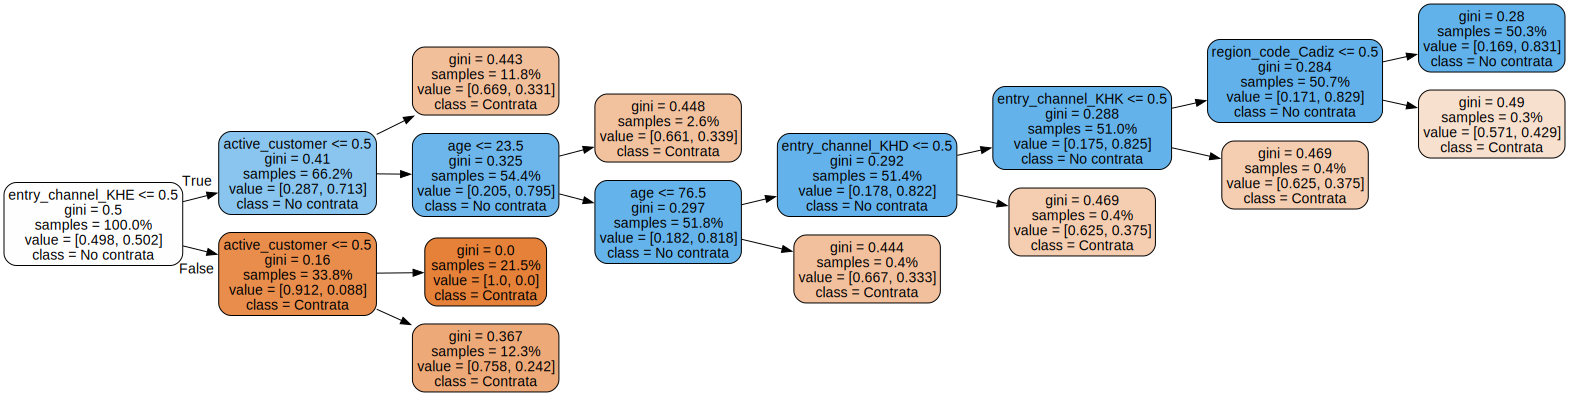

In [111]:
graphviz.Source(tree_model)

## Evaluar el modelo
### Accuracy

In [112]:
y_test_pred = pd.DataFrame(dt_basic.predict(X_test), index = y_test.index, columns = ['Predicción contratación'])
y_test_pred.head(5)
y_test.head(5)

,reg_credit_card
1601,1
1055,1
165,1
1554,0
990,0


Hacemos un join para obtener la matriz con los resultados predecidos y los reales

In [113]:
result_df = y_test.join(y_test_pred, how = 'inner')
result_df

,reg_credit_card,Predicción contratación
1601,1,1
1601,1,0
1055,1,1
165,1,1
1554,0,0
...,...,...
1908,0,0
1087,1,1
1466,1,1
368,0,1


Parece que el modelo predice contrataciones de más (falsos positivos), lo cual es mejor para estar preparados ante un exceso de clientes. Si hubiese falsos negativos, podría suponer sobrecarga de personal por exceso de clientes no previstos.

In [114]:
result_df['Success'] = (result_df['reg_credit_card'] == result_df['Predicción contratación'])

In [115]:
result_df.shape

(1060, 3)

In [116]:
result_df['Success'].sum()

782

In [117]:
#accuracy
result_df['Success'].mean()

0.7377358490566037

Vemos el accuracy es de 0.73 pero usaremos otras métricas de validación más complejas para ver si sale un resultado diferente.

### Confusion matrix

In [118]:
confusion_matrix = pd.crosstab(result_df['reg_credit_card'], result_df['Predicción contratación'])

In [119]:
1 - result_df['Success'].mean()
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]
TP = confusion_matrix.iloc[1,1]
accuracy = (TP + TN) / (TP + TN + FN + FP)
accuracy

0.7377358490566037

Coincide los resultados de la matriz de confusión con el accuracy. Es de 0.73.


### Overfitting

In [120]:
for i in range(1,10):
  #instanciar
  dt_overfit = DecisionTreeClassifier(max_depth=i,min_samples_split=200)
  #entrenar
  dt_overfit.fit(X_train, y_train)
  #evaluar
  accuracy_train = dt_overfit.score(X_train, y_train)
  accuracy_test = dt_overfit.score(X_test, y_test)
  print(f'Profundidad del arbol {i}, acc_train: {round(accuracy_train*100,2)}, accuracy_test: {round(accuracy_test*100,2)}, overfit {round(accuracy_train*100,2) - round(accuracy_test*100,2)}')

Profundidad del arbol 1, acc_train: 78.0, accuracy_test: 76.3, overfit 1.7000000000000028
Profundidad del arbol 2, acc_train: 82.0, accuracy_test: 80.09, overfit 1.9099999999999966
Profundidad del arbol 3, acc_train: 83.34, accuracy_test: 82.25, overfit 1.0900000000000034
Profundidad del arbol 4, acc_train: 83.48, accuracy_test: 82.25, overfit 1.230000000000004
Profundidad del arbol 5, acc_train: 83.57, accuracy_test: 82.25, overfit 1.3199999999999932
Profundidad del arbol 6, acc_train: 83.67, accuracy_test: 82.47, overfit 1.2000000000000028
Profundidad del arbol 7, acc_train: 83.71, accuracy_test: 82.14, overfit 1.5699999999999932
Profundidad del arbol 8, acc_train: 83.71, accuracy_test: 82.14, overfit 1.5699999999999932
Profundidad del arbol 9, acc_train: 83.76, accuracy_test: 82.03, overfit 1.730000000000004


Nos quedamos con una profundidad de 4 ya que vemos que el acc_test y el acc_train son los más elevados mientras el overfitting se mantiene con un valor bajo.

## Modelo final

Establecemos el modelo final definiendo los parámetros de overfitting con el max_depth.

In [121]:
dt_final = DecisionTreeClassifier(max_depth=4,min_samples_split=500)
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=500)

### Evaluar en validación

In [122]:
dt_final.score(X_train, y_train)
dt_final.score(X_test, y_test)

0.816017316017316

Le pasamos los datos de validación para ver como funciona y vemos que el resultado de validación es parecido a train y test.

In [123]:
dt_final.score(val_df_X, val_df_y)

0.8353361481000324

## AUC

In [124]:
metrics.roc_auc_score(y_test,dt_final.predict_proba(X_test)[:,1])

0.854459115017711

Obtenemos un AUC de 0,83. Se considera un buen modelo cuando el AUC es mayor a 0.75. Probaremos a realizar el random forest para mejorarlos 😎.

## ROC Curve

Text(0, 0.5, 'TPR')

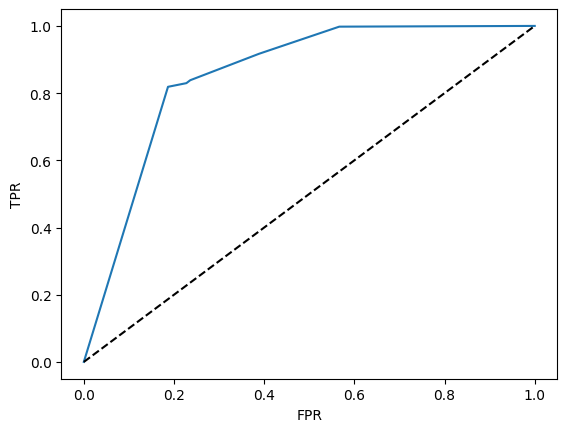

In [125]:
fpr,tpr,th = metrics.roc_curve(y_test,dt_final.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], color= 'black', linestyle = '--')
plt.xlabel('FPR')
plt.ylabel('TPR')

Tenemos TPR (Recall, ceros reales) más alta, por encima de la diagonal, y FPR (verdaderos negativos). Como la curva está por encima de la diagonal, quiere decir que el modelo predice con más aciertos (TP) que fallos (FP). También sabemos que el modelo es capaz de discernir con respecto al target, ya que la línea azul (ROC Curve) no se sobrepone a la diagonal negra.

# Modelos alternativos a DecisionTreeClassifier

## Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
rf_basic = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 42)

Entrenamos el modelo

In [128]:
rf_basic.fit(X = X_train, y = np.ravel(y_train))

RandomForestClassifier(max_depth=4, random_state=42)

Evaluamos el modelo. -- model.predict_proba() nos dice el porcentaje de probabilidad de predecir la clase del target

In [129]:
metrics.roc_auc_score(y_test,rf_basic.predict_proba(X_test)[:,1])
rf_basic.estimators_[1]

DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1273642419)

In [130]:
tree_data_rf0 = export_graphviz(
    decision_tree = rf_basic.estimators_[2],
    out_file=None,
    max_depth=8,
    feature_names=X_train.columns,
    class_names=['Contrata', 'No contrata'],
    filled=True,
    impurity=True,
    proportion=True,
    rotate=True,
    rounded=True
)

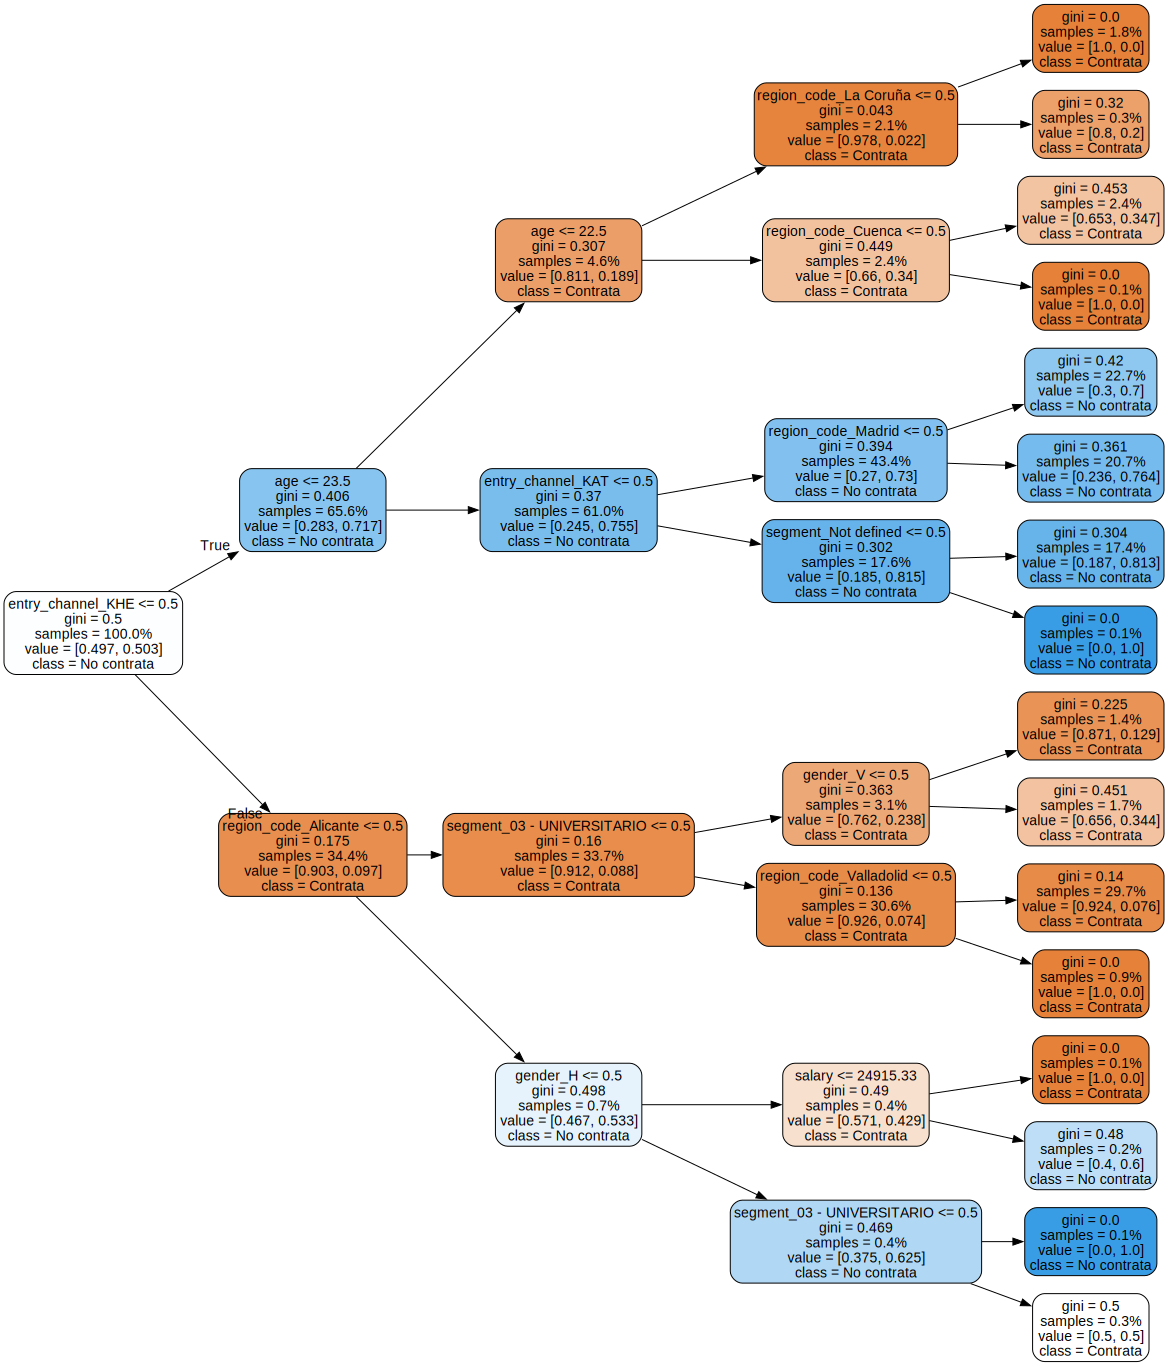

In [131]:
graphviz.Source(tree_data_rf0)

In [132]:
rf_basic.predict_proba(X_test)[:,1]
pd.Series(rf_basic.feature_importances_, index = X_test.columns).sort_values(ascending = False).head(20)

entry_channel_KHE             0.215727
age                           0.205506
active_customer               0.171085
segment_02 - PARTICULARES     0.085285
entry_channel_KFC             0.075447
segment_03 - UNIVERSITARIO    0.072698
entry_channel_KAT             0.052652
region_code_Madrid            0.035891
entry_channel_KHD             0.019677
salary                        0.012111
entry_channel_KFA             0.009064
segment_01 - TOP              0.005227
region_code_Badajoz           0.003877
region_code_Salamanca         0.003590
region_code_Cadiz             0.003516
gender_V                      0.002217
gender_H                      0.002195
region_code_Murcia            0.001765
region_code_Lerida            0.001539
region_code_Pontevedra        0.001278
dtype: float64

Parece ser que la columna entry_channel_KHE es la mas relevante en cuanto a la predicción del target

In [133]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=500, random_state=42)
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=4, min_samples_split=500, random_state=42)

Lanzamos el modelo sobre el conjunto de test para que haga sus predicciones

In [134]:
y_score = pd.DataFrame(rf.predict_proba(X_test)[:,1], index=y_test.index, columns=['reg_credit_card_score'])

In [135]:
y_score

,reg_credit_card_score
1601,0.708930
1055,0.692614
165,0.732378
1554,0.144660
990,0.683808
2668,0.572884
1574,0.690404
2786,0.665309
2797,0.536758
2077,0.468397


Comparamos las predicciones de y_score con los valores reales de y_test juntandolos en una tabla. En este caso, como hemos hecho un predict proba.

In [136]:
results_df = y_test.join(y_score)

In [137]:
results_df.head()

,reg_credit_card,reg_credit_card_score
1601,1,0.708930
1601,1,0.145712
1055,1,0.692614
165,1,0.732378
1554,0,0.144660


### AUC Score

In [138]:
print(metrics.roc_auc_score(results_df['reg_credit_card'], results_df['reg_credit_card_score']))

0.7768367012716993


### ROC Curve

In [139]:
fpr, tpr, _ = metrics.roc_curve(results_df['reg_credit_card'], results_df['reg_credit_card_score'])

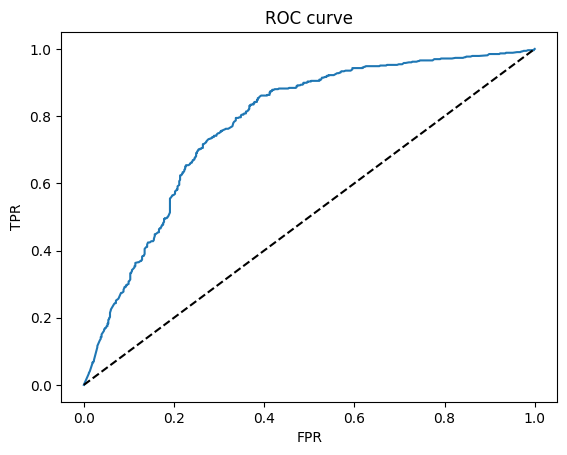

In [140]:
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

El ROC Curve nos dice que se predicen más TP que FP y que además el modelo es capaz de discernir entre las características para predecir el target.

Con el random forest no hemos conseguido mejorar los parámetros de validación de AUC y ROC curve.

In [141]:
results_df['reg_credit_card_score'].nunique()

641

In [142]:
results_df['Decile'] = pd.qcut(results_df['reg_credit_card_score'], q=10)

In [143]:
results_df.head(10)

,reg_credit_card,reg_credit_card_score,Decile
1601,1,0.708930,"(0.706, 0.717]"
1601,1,0.145712,"(0.135, 0.149]"
1055,1,0.692614,"(0.58, 0.693]"
165,1,0.732378,"(0.729, 0.749]"
1554,0,0.144660,"(0.135, 0.149]"
990,0,0.683808,"(0.58, 0.693]"
2668,0,0.572884,"(0.49, 0.58]"
2668,0,0.745509,"(0.729, 0.749]"
1574,1,0.690404,"(0.58, 0.693]"
2786,1,0.665309,"(0.58, 0.693]"


In [144]:
results_summary_table = results_df.pivot_table(index='Decile', values='reg_credit_card', aggfunc=[len, 'sum', 'mean'], observed=False).sort_index(ascending=False)

In [145]:
results_summary_table.columns = ['Cases', 'Responses', 'Accuracy']

In [146]:
results_summary_table

,Cases,Responses,Accuracy
Decile,,,
"(0.729, 0.749]",100,79,0.790000
"(0.717, 0.729]",112,80,0.714286
"(0.706, 0.717]",106,75,0.707547
"(0.693, 0.706]",104,77,0.740385
"(0.58, 0.693]",104,70,0.673077
"(0.49, 0.58]",110,57,0.518182
"(0.246, 0.49]",106,37,0.349057
"(0.22, 0.246]",106,24,0.226415
"(0.149, 0.22]",105,13,0.123810


In [147]:
def get_gain_table(model, X_test, y_test):
    y_score = pd.DataFrame(model.predict_proba(X_test)[:,1], index=y_test.index, columns=['Score'])
    results_df = y_test.join(y_score)
    results_df['Decile'] = pd.qcut(results_df['Score'], q=10)
    results_summary_table = results_df.pivot_table(index='Decile', values=y_test.columns, aggfunc=[len, 'sum', 'mean'], observed=False).sort_index(ascending=False)
    results_summary_table.columns = ['Cases', 'Responses', 'Accuracy']
    results_summary_table['Pct. Cases'] = results_summary_table['Cases'] / results_summary_table['Cases'].sum()
    results_summary_table['Pct. Responses'] = results_summary_table['Responses'] / results_summary_table['Responses'].sum()
    results_summary_table['Cum. Cases'] = results_summary_table['Cases'].cumsum()
    results_summary_table['Cum. Responses'] = results_summary_table['Responses'].cumsum()
    results_summary_table['Cum. Pct. Cases'] = results_summary_table['Pct. Cases'].cumsum()
    results_summary_table['Cum. Pct. Responses'] = results_summary_table['Pct. Responses'].cumsum()
    return results_summary_table

In [148]:
rf_results_summary_table = get_gain_table(rf, X_test, y_test)

In [149]:
rf_results_summary_table

,Cases,Responses,Accuracy,Pct. Cases,Pct. Responses,Cum. Cases,Cum. Responses,Cum. Pct. Cases,Cum. Pct. Responses
Decile,,,,,,,,,
"(0.729, 0.749]",100,79,0.790000,0.094340,0.150190,100,79,0.094340,0.150190
"(0.717, 0.729]",112,80,0.714286,0.105660,0.152091,212,159,0.200000,0.302281
"(0.706, 0.717]",106,75,0.707547,0.100000,0.142586,318,234,0.300000,0.444867
"(0.693, 0.706]",104,77,0.740385,0.098113,0.146388,422,311,0.398113,0.591255
"(0.58, 0.693]",104,70,0.673077,0.098113,0.133080,526,381,0.496226,0.724335
"(0.49, 0.58]",110,57,0.518182,0.103774,0.108365,636,438,0.600000,0.832700
"(0.246, 0.49]",106,37,0.349057,0.100000,0.070342,742,475,0.700000,0.903042
"(0.22, 0.246]",106,24,0.226415,0.100000,0.045627,848,499,0.800000,0.948669
"(0.149, 0.22]",105,13,0.123810,0.099057,0.024715,953,512,0.899057,0.973384


In [150]:
rf_basic.score(X_train, y_train)

0.822737819025522

In [151]:
rf_basic.score(X_test, y_test)

0.8138528138528138

In [152]:
rf_basic.score(val_df_X, val_df_y)

0.827866190321533

## Resultados

### Visulaización del dataframe resultante

In [153]:
rf_results_summary_table

,Cases,Responses,Accuracy,Pct. Cases,Pct. Responses,Cum. Cases,Cum. Responses,Cum. Pct. Cases,Cum. Pct. Responses
Decile,,,,,,,,,
"(0.729, 0.749]",100,79,0.790000,0.094340,0.150190,100,79,0.094340,0.150190
"(0.717, 0.729]",112,80,0.714286,0.105660,0.152091,212,159,0.200000,0.302281
"(0.706, 0.717]",106,75,0.707547,0.100000,0.142586,318,234,0.300000,0.444867
"(0.693, 0.706]",104,77,0.740385,0.098113,0.146388,422,311,0.398113,0.591255
"(0.58, 0.693]",104,70,0.673077,0.098113,0.133080,526,381,0.496226,0.724335
"(0.49, 0.58]",110,57,0.518182,0.103774,0.108365,636,438,0.600000,0.832700
"(0.246, 0.49]",106,37,0.349057,0.100000,0.070342,742,475,0.700000,0.903042
"(0.22, 0.246]",106,24,0.226415,0.100000,0.045627,848,499,0.800000,0.948669
"(0.149, 0.22]",105,13,0.123810,0.099057,0.024715,953,512,0.899057,0.973384


### Ranking de clientes actuales propensos a compra

Cogemos los clientes de la última particion


In [154]:
df_con_reg_merged

,pk_cid,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary,reg_credit_card
0,1050611,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74,0
1,1050612,2018-01-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11,0
2,1050613,2018-01-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54,0
3,1050614,2018-01-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00,0
4,1050615,2018-01-01,KHE,0,03 - UNIVERSITARIO,45,H,23,22220.04,0
...,...,...,...,...,...,...,...,...,...,...
1047514,1018682,2019-05-01,KAT,0,02 - PARTICULARES,28,V,88,35310.57,0
1047515,1018679,2019-05-01,KFA,1,02 - PARTICULARES,28,V,34,61180.11,0
1047516,1018676,2019-05-01,KFA,0,02 - PARTICULARES,28,H,74,63867.48,0
1047517,1018675,2019-05-01,KFC,0,02 - PARTICULARES,29,H,15,-1.00,0


In [155]:
df_ranking=df_merged.loc[df_merged['pk_partition'] =='2019-05']

Adaptamos el df para el ranking con las mismas columnas del dataframe para el modelo. Para ello, cambiamos el region_code por el nombre de la probincia

In [156]:
# Diccionario que mapea los códigos de región a nombres
codigo_a_nombre = {
    1: 'Alava',
    2: 'Albacete',
    3: 'Alicante',
    4: 'Almeria',
    5: 'Avila',
    6: 'Badajoz',
    7: 'Islas Baleares',
    8: 'Barcelona',
    9: 'Burgos',
    10: 'Caceres',
    11: 'Cadiz',
    12: 'Castellon',
    13: 'Ciudad Real',
    14: 'Cordoba',
    15: 'La Coruña',
    16: 'Cuenca',
    17: 'Gerona',
    18: 'Granada',
    19: 'Guadalajara',
    20: 'Guipuzcoa',
    21: 'Huelva',
    22: 'Huesca',
    23: 'Jaen',
    24: 'Leon',
    25: 'Lerida',
    26: 'La Rioja',
    27: 'Lugo',
    28: 'Madrid',
    29: 'Malaga',
    30: 'Murcia',
    31: 'Navarra',
    32: 'Orense',
    33: 'Asturias',
    34: 'Palencia',
    35: 'Las Palmas',
    36: 'Pontevedra',
    37: 'Salamanca',
    38: 'Santa Cruz de Tenerife',
    39: 'Cantabria',
    40: 'Segovia',
    41: 'Sevilla',
    42: 'Soria',
    43: 'Tarragona',
    44: 'Teruel',
    45: 'Toledo',
    46: 'Valencia',
    47: 'Valladolid',
    48: 'Vizcaya',
    49: 'Zamora',
    50: 'Zaragoza',
    51: 'Ceuta',
    52: 'Melilla'
}

# Reemplaza los valores en la columna 'region_code' usando el diccionario
df_ranking['region_code'] = df_ranking['region_code'].replace(codigo_a_nombre)

# Muestra el DataFrame para verificar los cambios
print(df_ranking)

          pk_cid pk_partition entry_channel  active_customer  \
5516831   657826   2019-05-01        Others                1   
5516832   657817   2019-05-01   Not defined                0   
5516833   657986   2019-05-01        Others                1   
5516834   657905   2019-05-01           KAT                1   
5516835   657336   2019-05-01           KAT                1   
...          ...          ...           ...              ...   
5959572  1166765   2019-05-01           KHE                0   
5959573  1166764   2019-05-01           KHE                0   
5959574  1166763   2019-05-01           KHE                1   
5959575  1166789   2019-05-01           KHE                0   
5959576  1550586   2019-05-01   Not defined                1   

                    segment region_code gender  age     salary  
5516831   02 - PARTICULARES      Lerida      H   44   54493.38  
5516832         Not defined   Barcelona      V   32      -1.00  
5516833   02 - PARTICULARES     Sevi

/var/folders/pb/jt3p2kyx2hx__2r9dsl0gsv80000gn/T/ipykernel_22837/1570508301.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ranking['region_code'] = df_ranking['region_code'].replace(codigo_a_nombre)


Definicmos el index con el pk_cid porque nos servirá posteriormente para identificar a los clientes a los clientes incluidos en el ranking, así como su cluster

In [157]:
df_ranking.set_index('pk_cid', inplace=True)

In [158]:
df_ranking

,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary
pk_cid,,,,,,,,
657826,2019-05-01,Others,1,02 - PARTICULARES,Lerida,H,44,54493.38
657817,2019-05-01,Not defined,0,Not defined,Barcelona,V,32,-1.00
657986,2019-05-01,Others,1,02 - PARTICULARES,Sevilla,H,39,100993.17
657905,2019-05-01,KAT,1,01 - TOP,Madrid,H,85,154059.09
657336,2019-05-01,KAT,1,02 - PARTICULARES,Madrid,V,38,-1.00
...,...,...,...,...,...,...,...,...
1166765,2019-05-01,KHE,0,03 - UNIVERSITARIO,Zaragoza,V,22,43912.17
1166764,2019-05-01,KHE,0,03 - UNIVERSITARIO,La Rioja,V,23,23334.99
1166763,2019-05-01,KHE,1,02 - PARTICULARES,Zaragoza,H,47,-1.00


In [159]:
df_ranking.index.name = None

In [160]:
df_ranking

,pk_partition,entry_channel,active_customer,segment,region_code,gender,age,salary
657826,2019-05-01,Others,1,02 - PARTICULARES,Lerida,H,44,54493.38
657817,2019-05-01,Not defined,0,Not defined,Barcelona,V,32,-1.00
657986,2019-05-01,Others,1,02 - PARTICULARES,Sevilla,H,39,100993.17
657905,2019-05-01,KAT,1,01 - TOP,Madrid,H,85,154059.09
657336,2019-05-01,KAT,1,02 - PARTICULARES,Madrid,V,38,-1.00
...,...,...,...,...,...,...,...,...
1166765,2019-05-01,KHE,0,03 - UNIVERSITARIO,Zaragoza,V,22,43912.17
1166764,2019-05-01,KHE,0,03 - UNIVERSITARIO,La Rioja,V,23,23334.99
1166763,2019-05-01,KHE,1,02 - PARTICULARES,Zaragoza,H,47,-1.00
1166789,2019-05-01,KHE,0,03 - UNIVERSITARIO,Zaragoza,H,22,199592.82


In [161]:
object_columns = [col for col in df_ranking if df_ranking[col].dtype.kind == 'O']

In [162]:
for col in object_columns:
    _dummy_dataset = pd.get_dummies(df_ranking[col], prefix=col)
    df_ranking = pd.concat([df_ranking,_dummy_dataset],axis=1)
    df_ranking.drop([col],axis=1, inplace=True)

In [163]:
df_ranking.info()


<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 74 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pk_partition                        442746 non-null  datetime64[ns]
 1   active_customer                     442746 non-null  int64         
 2   age                                 442746 non-null  int64         
 3   salary                              442746 non-null  float64       
 4   entry_channel_KAT                   442746 non-null  bool          
 5   entry_channel_KFA                   442746 non-null  bool          
 6   entry_channel_KFC                   442746 non-null  bool          
 7   entry_channel_KHD                   442746 non-null  bool          
 8   entry_channel_KHE                   442746 non-null  bool          
 9   entry_channel_KHK                   442746 non-null  bool          
 10  entry_c

In [164]:
bool_columns = [col for col in df_ranking if df_ranking[col].dtype.kind == 'b']

In [165]:
for col in bool_columns:
    if col in df_ranking:
        df_ranking[col]=  df_ranking[col].astype('int32')

In [166]:
df_ranking.drop(columns=['pk_partition'], axis=1, inplace=True)

In [167]:
df_ranking.head()

,active_customer,age,salary,entry_channel_KAT,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
657826,1,44,54493.38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657817,0,32,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
657986,1,39,100993.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657905,1,85,154059.09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657336,1,38,-1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Finalmente, hacemos un predict_proba para obtener el ranking de clientes propensos a la compra de credit card.

In [168]:
clients_ranking = pd.DataFrame(rf.predict_proba(df_ranking)[:,1], index=df_ranking.index, columns=['reg_credit_card_score'])

In [169]:
clients_ranking 

,reg_credit_card_score
657826,0.629868
657817,0.476704
657986,0.689299
657905,0.702421
657336,0.733475
...,...
1166765,0.149271
1166764,0.157040
1166763,0.465412
1166789,0.151505


In [170]:
clients_ranking=clients_ranking.sort_values(by='reg_credit_card_score', ascending=False)

In [171]:
clients_ranking

,reg_credit_card_score
1016531,0.748693
1001578,0.748693
1121318,0.748693
1298457,0.748693
1019154,0.748693
...,...
1163919,0.134893
1077256,0.134893
1029690,0.134893
1076051,0.134893


Miramos cuantos clientes superan un rango aceptable de probabilidad de compra que establecemos como 65%.

In [172]:
len(clients_ranking.loc[clients_ranking['reg_credit_card_score']>0.65])

63814

In [173]:
clients_ranking.mean()

reg_credit_card_score    0.364544
dtype: float64

In [174]:
clients_ranking=clients_ranking.loc[clients_ranking['reg_credit_card_score']>0.65]

In [175]:
index_df = clients_ranking.index

In [176]:
df_ranking = pd.DataFrame(index_df)

In [178]:
df_ranking.to_csv(DATA_PATH+'df_ranking_credit_card.csv', index=False)